## Notebook settings

In [2]:
%load_ext autoreload
%autoreload 2

# %matplotlib widget

## Imports

In [3]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import uproot
import logging
import tpvalidator.mcprod.workspace as workspace
import tpvalidator.utilities as utils
import tpvalidator.mcprod.analyzers.snn as snn

from rich import print
from tpvalidator.utilities import temporary_log_level, subplot_autogrid, pandas_backend
from tpvalidator.histograms import uproot_hist_mean_std


# Load ADC mean and standard deviation from wafevorm histograms

In [4]:
with temporary_log_level(workspace.TriggerPrimitivesWorkspace._log, logging.INFO):
    ws = workspace.TriggerPrimitivesWorkspace("../../data/vd/bkg/100events/trigtree_tpg_vd_radiols.root")

print(ws.info)

INFO:TriggerPrimitivesWorkspace:tpmakerTPCSimpleThreshold__TriggerPrimitiveMaker found with 1552294 rows


None

{
    'backtracker': {'TPAlgTPCSimpleThreshold': {'offset_U': 8, 'offset_V': 1, 'offset_X': -7}},
    'geo': {'detector': 'dunevd10kt_3view_30deg_v5_refactored_1x8x6ref'},
    'tpg': {
        'tpmakerTPCSimpleThreshold::TriggerPrimitiveMaker': {
            'threshold_tpg_plane0': 38,
            'threshold_tpg_plane1': 38,
            'threshold_tpg_plane2': 44,
            'tool': 'TPAlgTPCSimpleThreshold'
        }
    }
}

In [5]:
ws.add_rawdigits('../../data/vd/bkg/100events/trigger_digits_waves_detsim_vd_radiols.root')

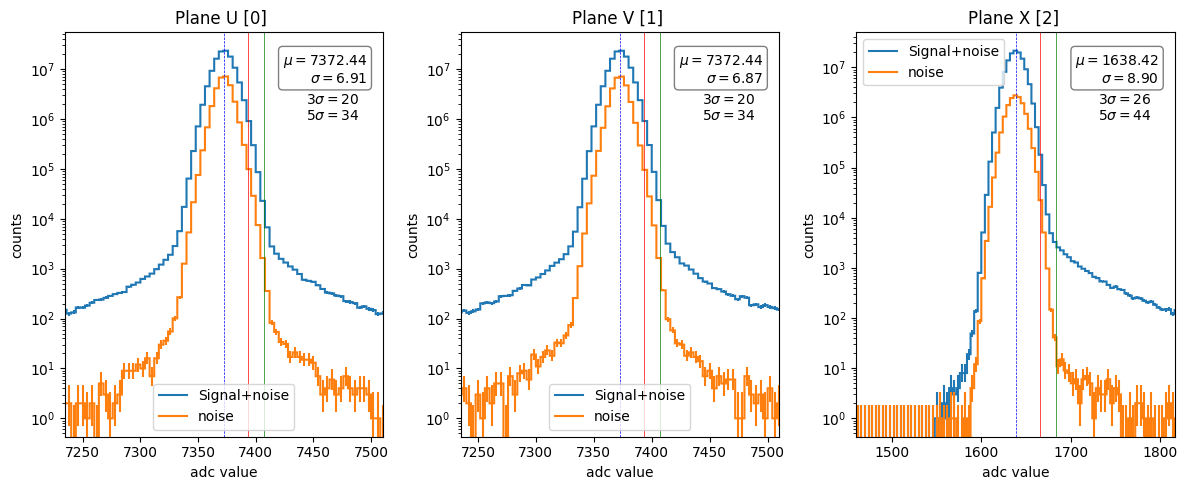

In [6]:
fig = snn.draw_signal_and_noise_adc_distros(ws)

# TP sample validation
## Distribution of point of origin in the detector

In [7]:
all_tps = snn.TPSignalNoiseSelector(ws.tps)
alltp_ana = snn.TPSignalNoiseAnalyzer(all_tps)

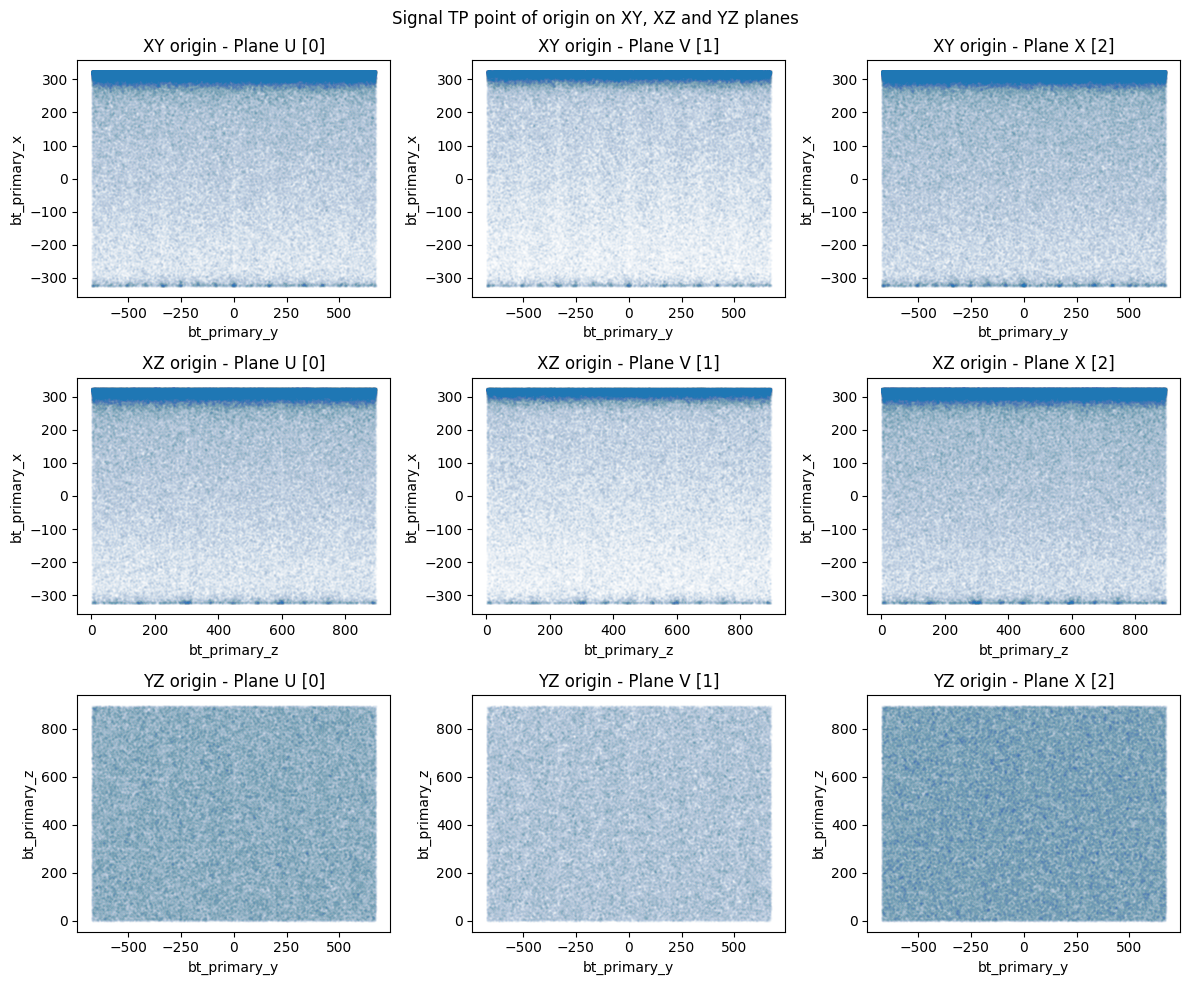

In [8]:
fig = alltp_ana.draw_tp_sig_origin_2d_dist()
fig.tight_layout()

In [9]:
pd.options.plotting.backend = 'plotly'
import plotly.express as px
# ws.tps.query('event == 1 & TP_peakADC > 50').plot.scatter(x='TP_channel', y='TP_peakT', size='TP_peakADC', color_continuous_scale=px.colors.sequential.Viridis, height=500, width=600)

pd.options.plotting.backend = 'matplotlib'
with pandas_backend('plotly') as x:
    f = ws.tps.query('event == 1 & adc_peak > 45 & readout_view == 2').plot.scatter(x='channel', y='time_start', size='adc_peak', color="bt_is_signal", color_continuous_scale=px.colors.sequential.Viridis, height=800, width=900)
    f.show()


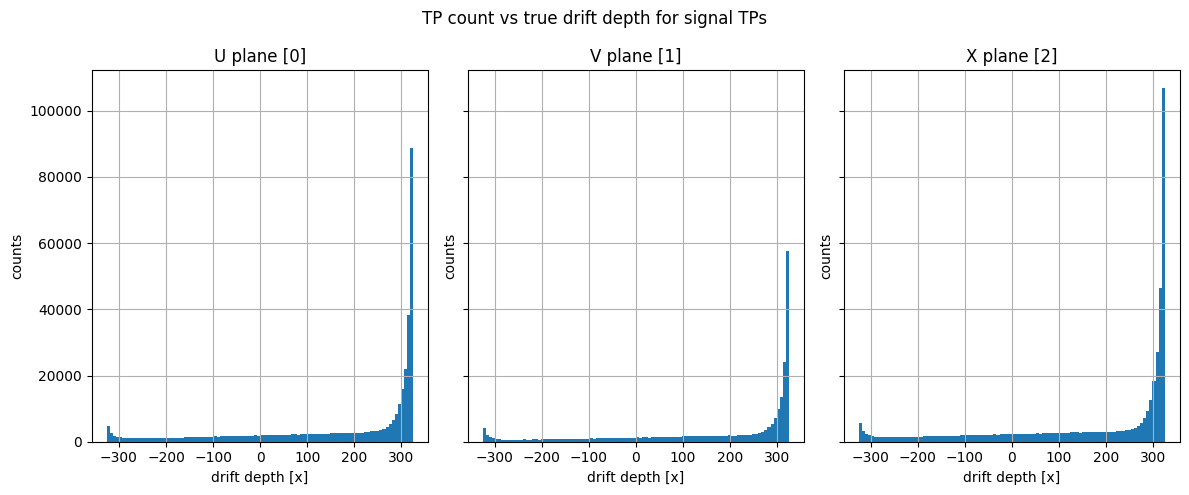

In [10]:
fig = alltp_ana.draw_tp_sig_drift_depth_dist()

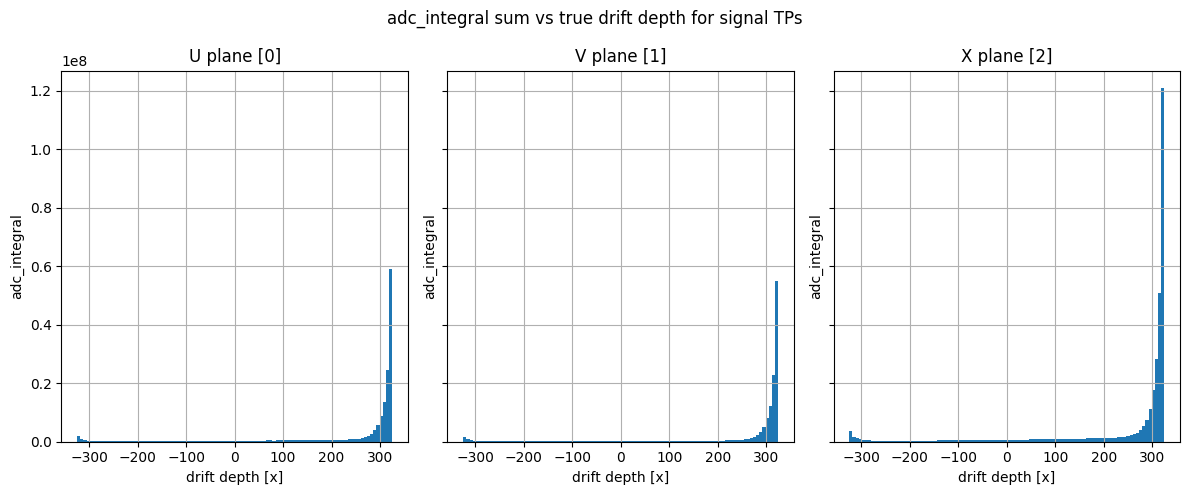

In [10]:
fig = alltp_ana.draw_tp_sig_drift_depth_dist(weight_by='adc_integral')

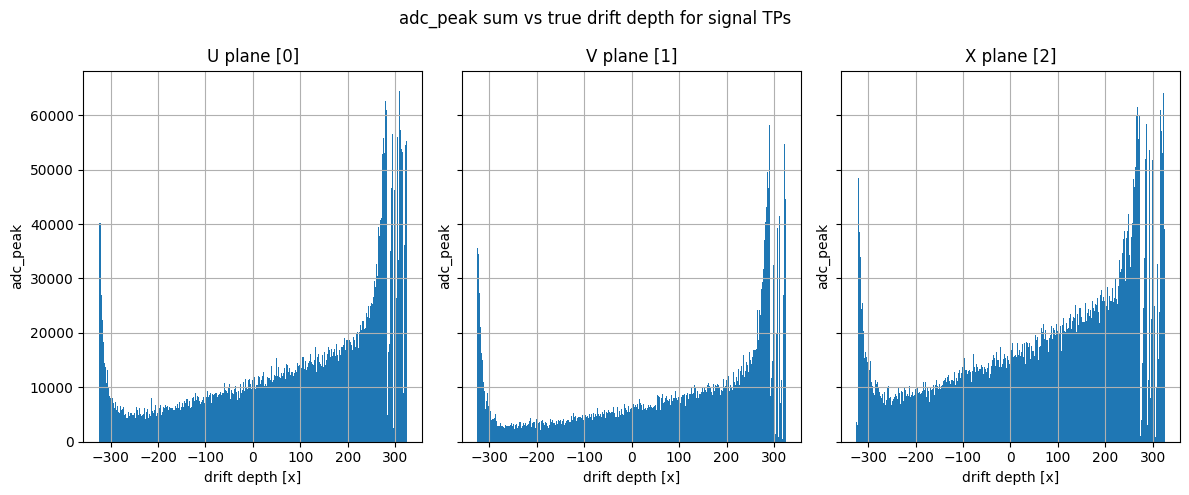

In [11]:
fig = alltp_ana.draw_tp_sig_drift_depth_dist(weight_by='adc_peak', bins=1000)

# Dataset validation: TP distributions

### TP distribution in channel and time - one event with increasing peak ADC cuts

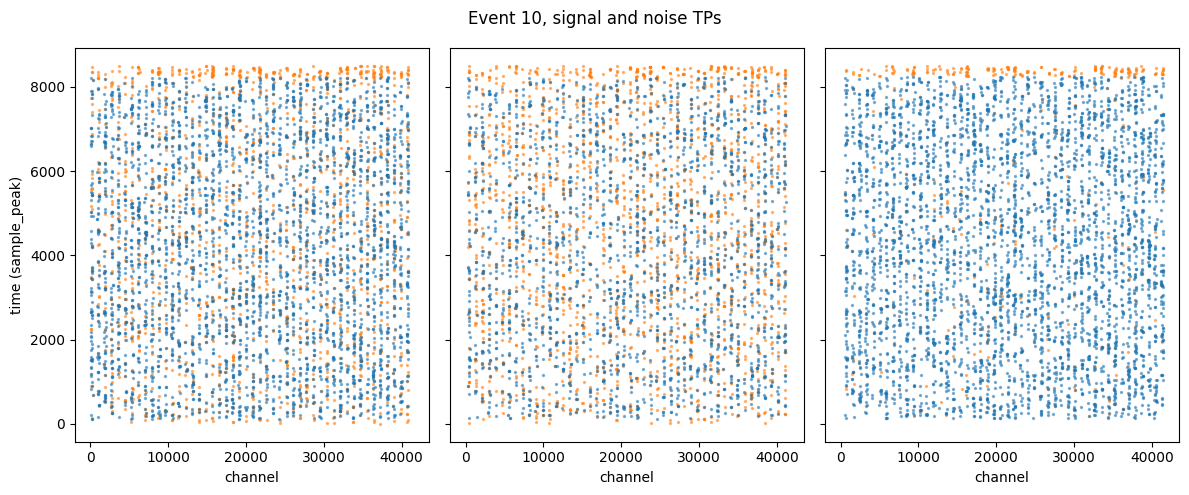

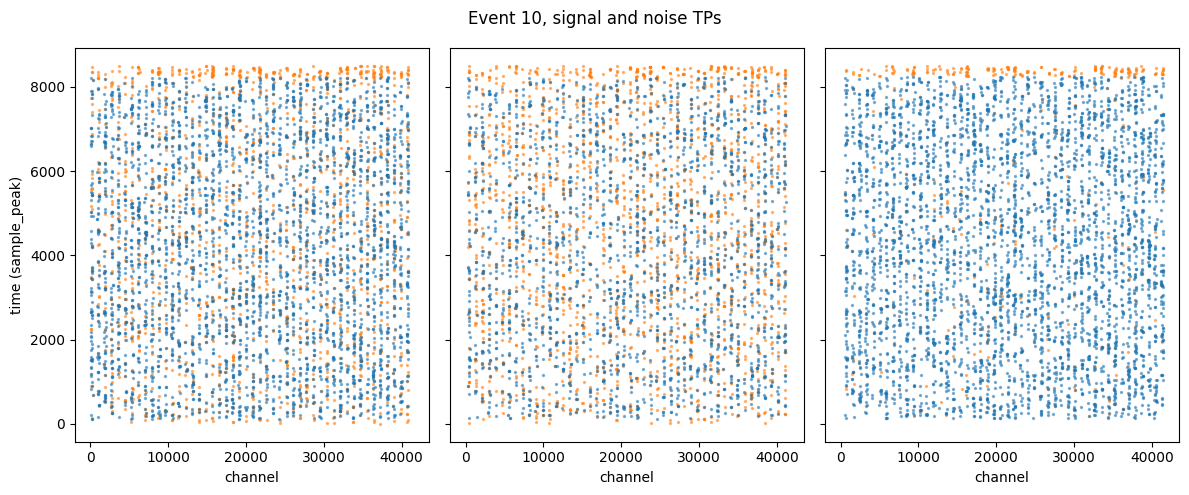

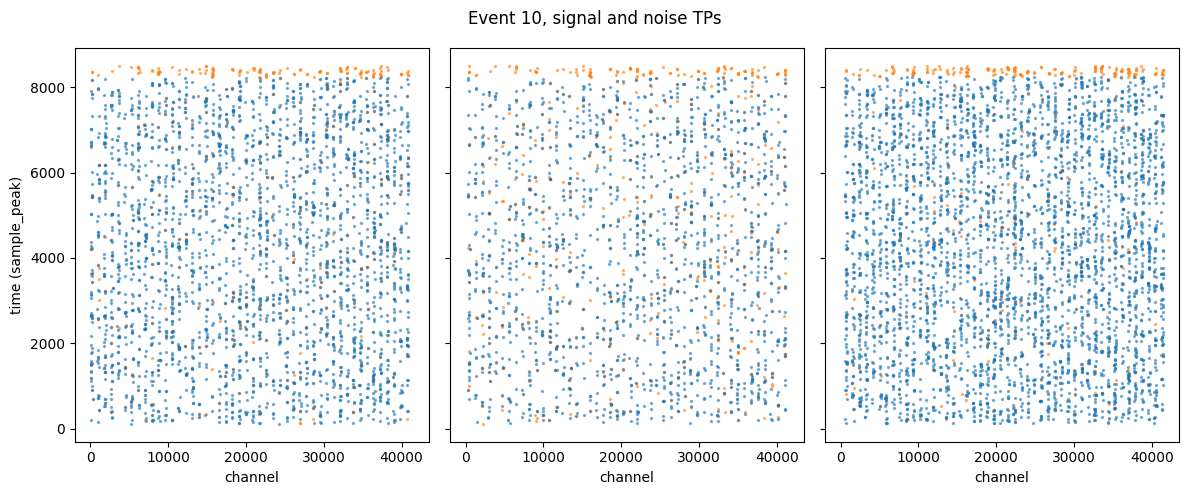

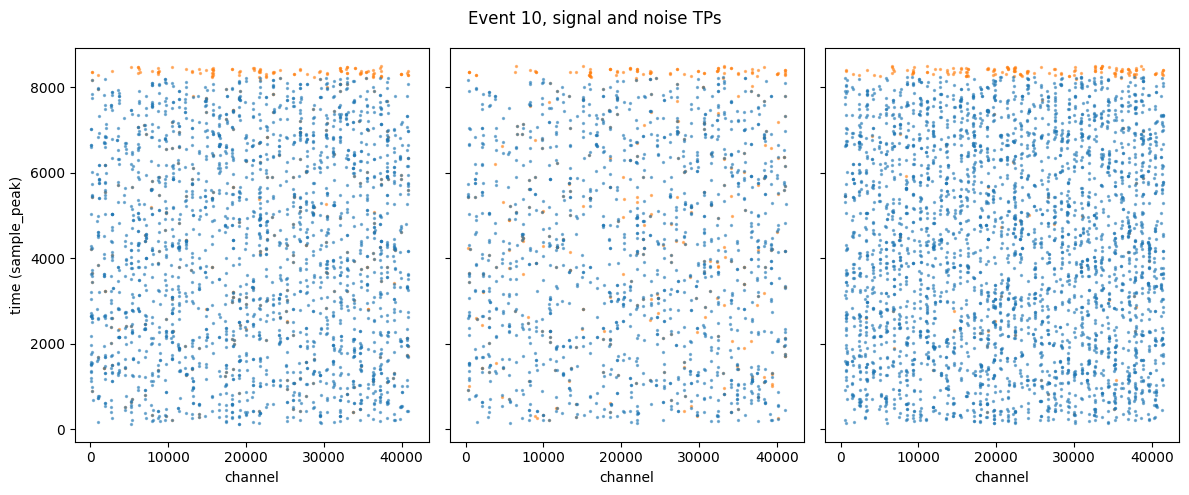

In [12]:
x = snn.TPSignalNoiseAnalyzer(all_tps.query('adc_peak > 26'))
fig = x.draw_tp_event(10)
x = snn.TPSignalNoiseAnalyzer(all_tps.query('adc_peak > 36'))
fig = x.draw_tp_event(10)
x = snn.TPSignalNoiseAnalyzer(all_tps.query('adc_peak > 46'))
fig = x.draw_tp_event(10)
x = snn.TPSignalNoiseAnalyzer(all_tps.query('adc_peak > 56'))
fig = x.draw_tp_event(10)


### TP distribution in channel and time - all events

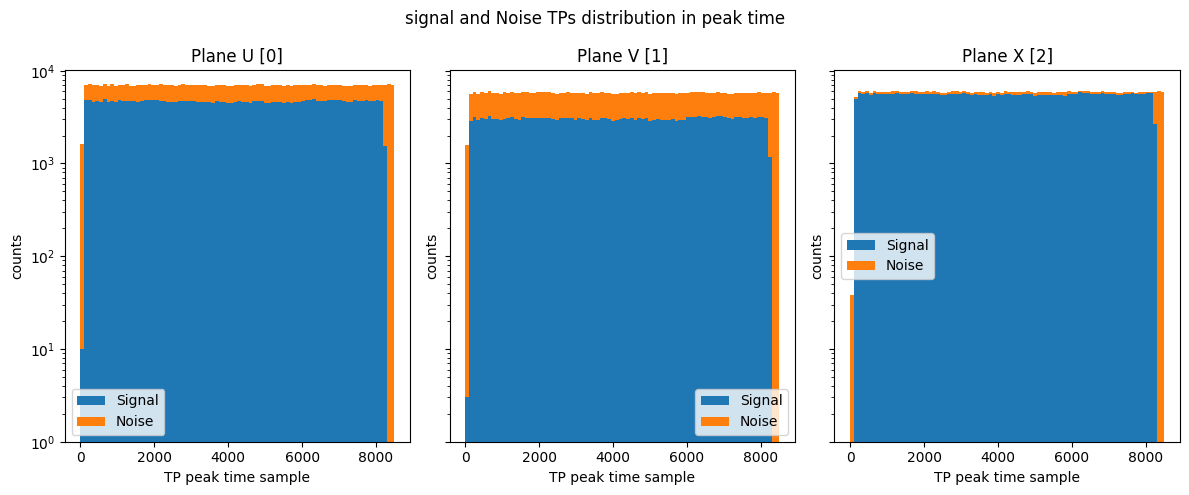

In [13]:
fig = alltp_ana.draw_tp_start_sample_dist()

# Cleaning: removing regions with non-even backtracking efficiency

In [14]:
tpw = snn.TPSignalNoiseSelector(ws.tps[(ws.tps.sample_start >100) & (ws.tps.sample_start <8100)])
tp_ana = snn.TPSignalNoiseAnalyzer(tpw)

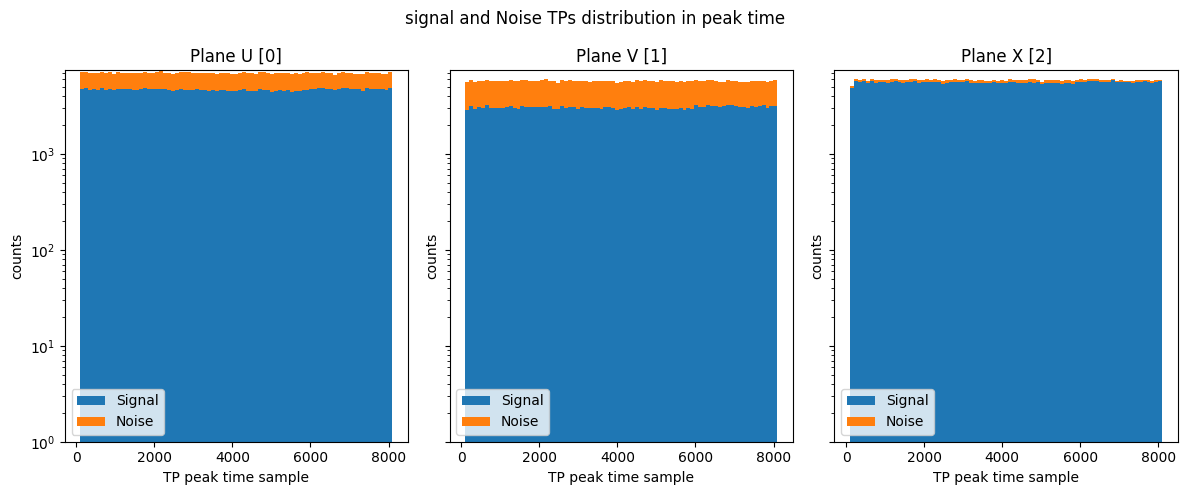

In [15]:
fig = tp_ana.draw_tp_start_sample_dist()


# adcpeak, time-over-threshold and SumADC distribution for Ar39 and noise

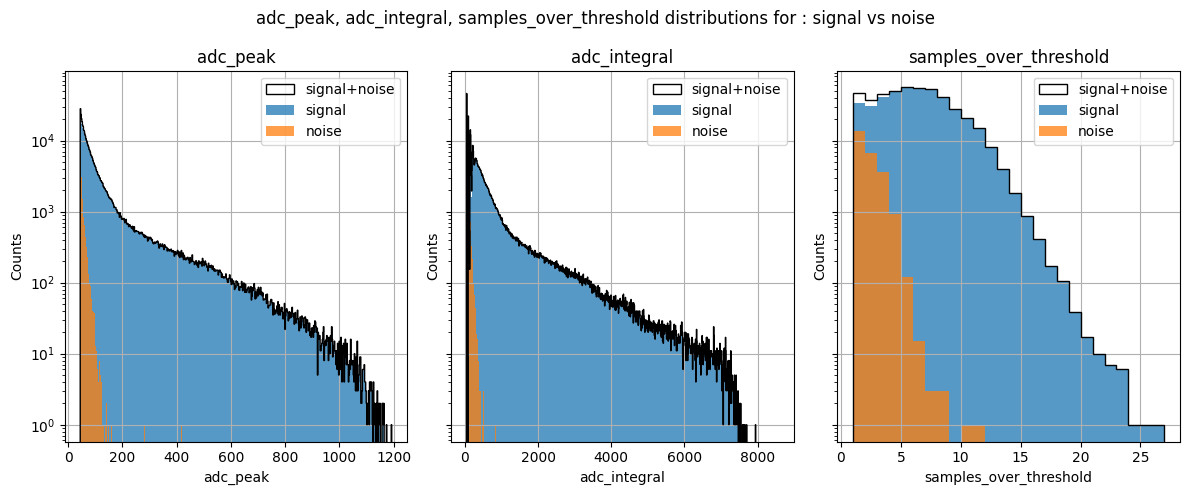

In [16]:
fig = tp_ana.draw_tp_signal_noise_dist()
fig.tight_layout()

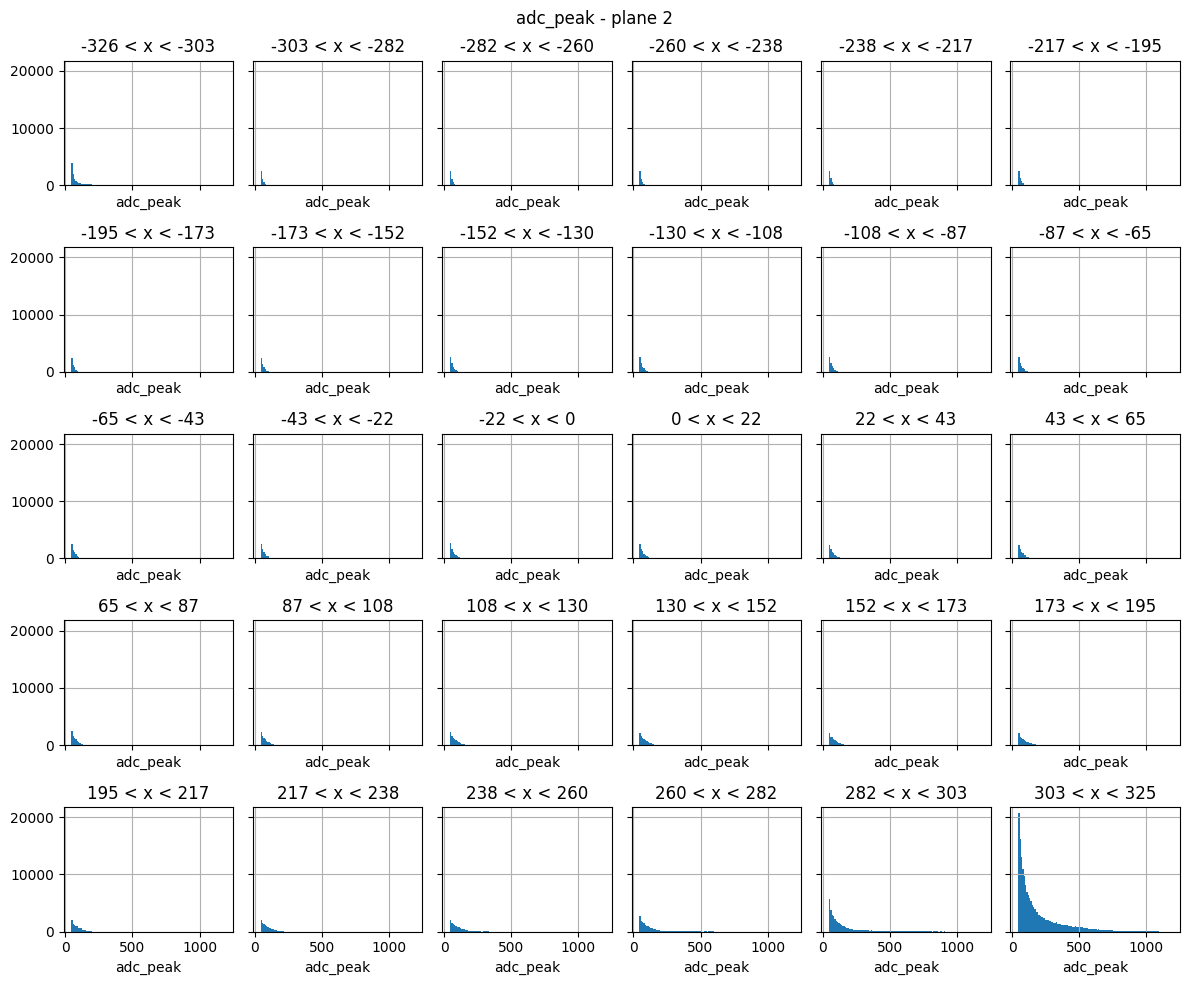

In [17]:
fig = tp_ana.draw_variable_in_drift_grid('adc_peak', downsampling=10, sharex=True, sharey=True, figsize=(12,10))
fig.tight_layout()

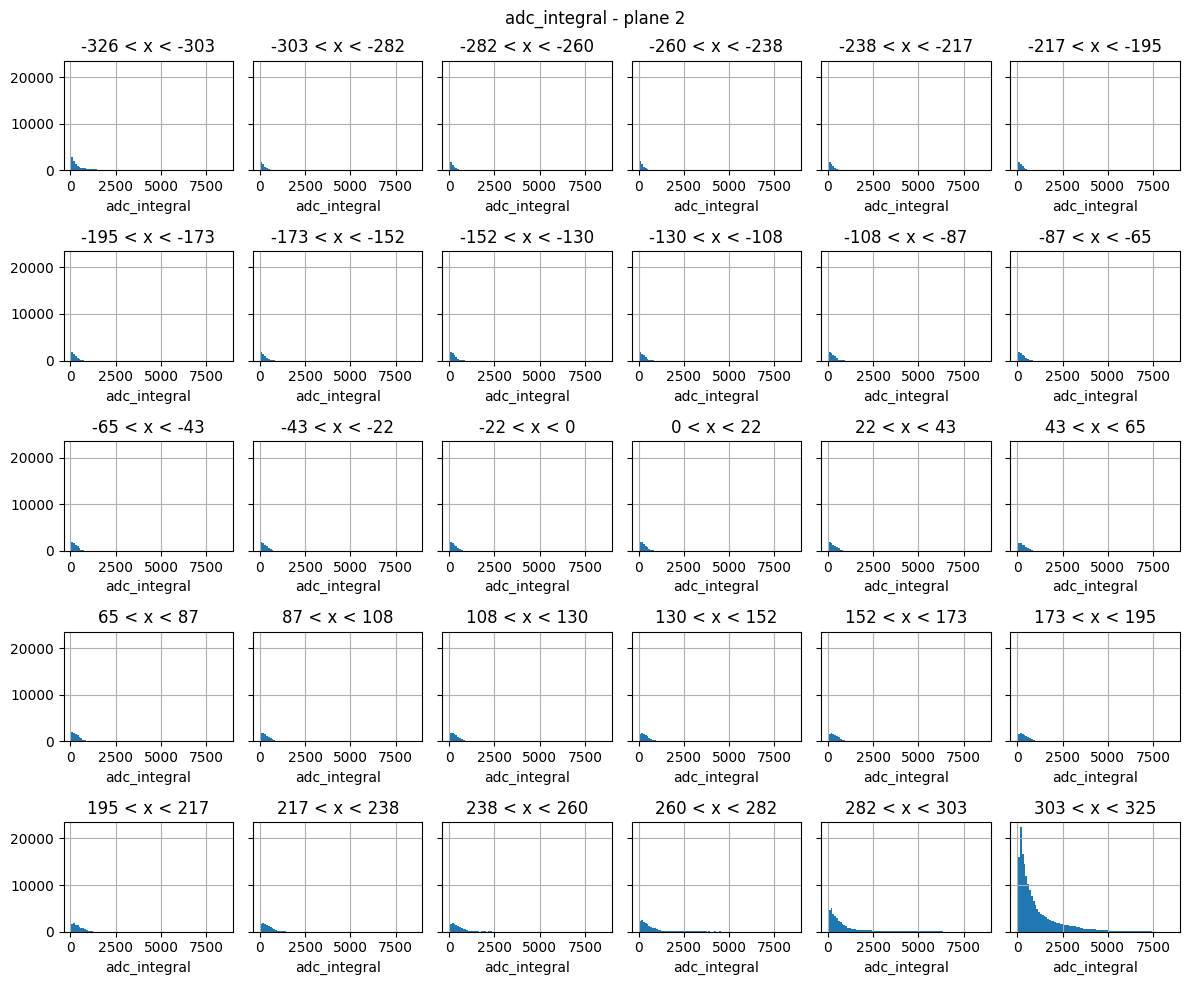

In [18]:
fig = tp_ana.draw_variable_in_drift_grid('adc_integral', downsampling=100, sharey=True, figsize=(12,10))
fig.tight_layout()

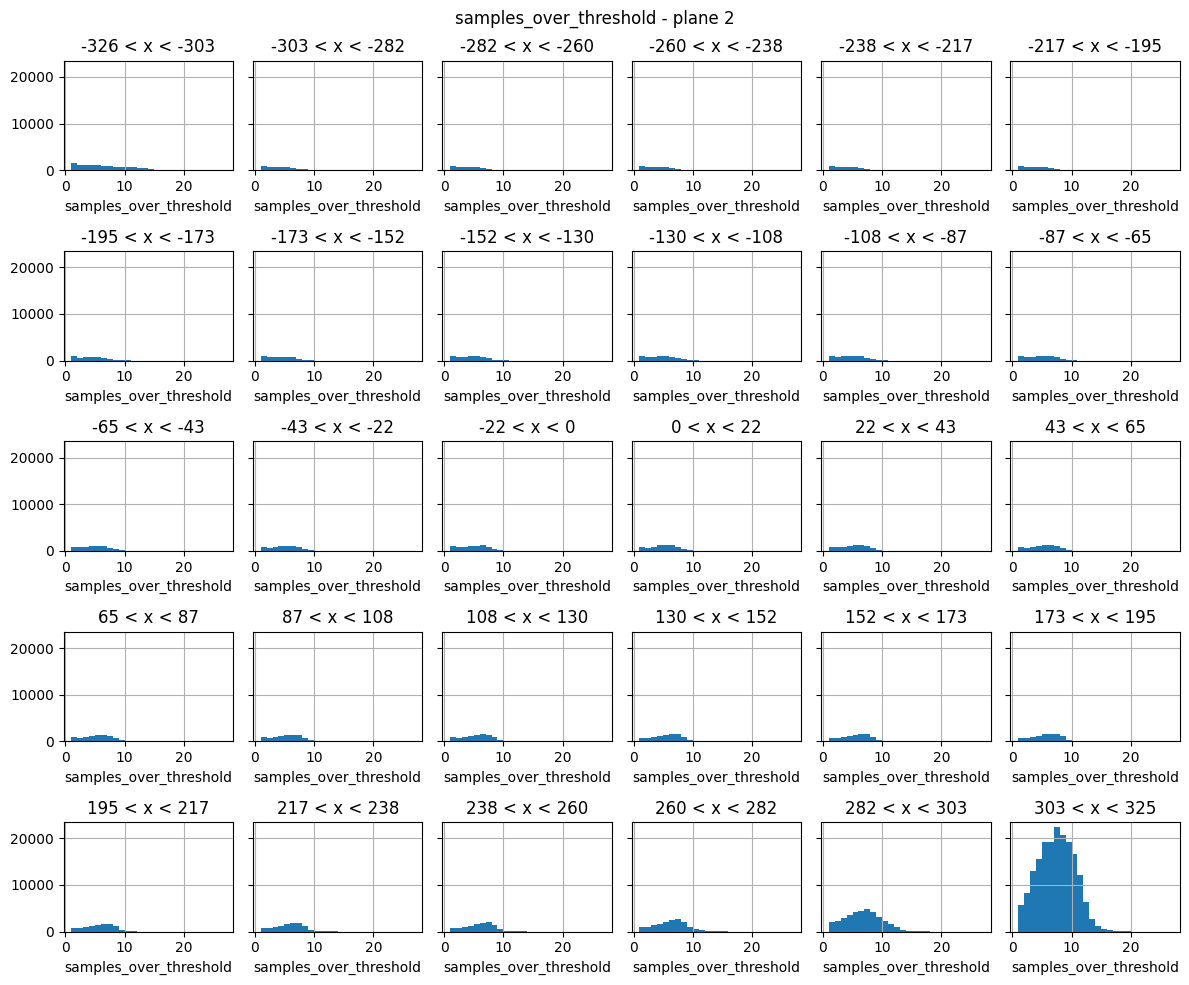

In [19]:
fig = tp_ana.draw_variable_in_drift_grid('samples_over_threshold', downsampling=1, log=False, sharey=True, figsize=(12,10))
fig.tight_layout()

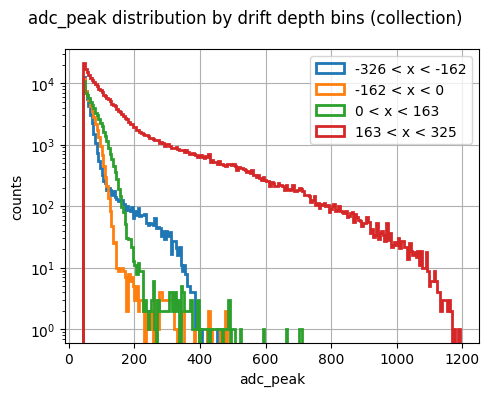

In [20]:
fig = tp_ana.draw_variable_drift_stack('adc_peak', downsampling=5, n_x_bins=4, log=True, figsize=(5,4))
fig.tight_layout()

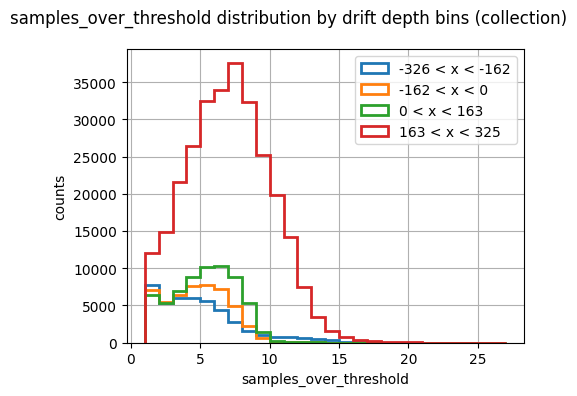

In [21]:
fig = tp_ana.draw_variable_drift_stack('samples_over_threshold', downsampling=1, n_x_bins=4, log=False, figsize=(5,4))
fig.tight_layout()


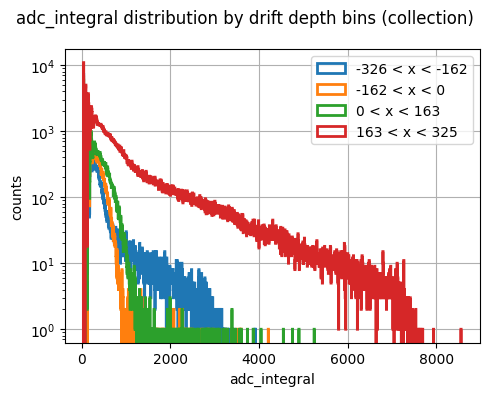

In [22]:
fig = tp_ana.draw_variable_drift_stack('adc_integral', downsampling=5, n_x_bins=4, log=True, figsize=(5,4))
fig.tight_layout()


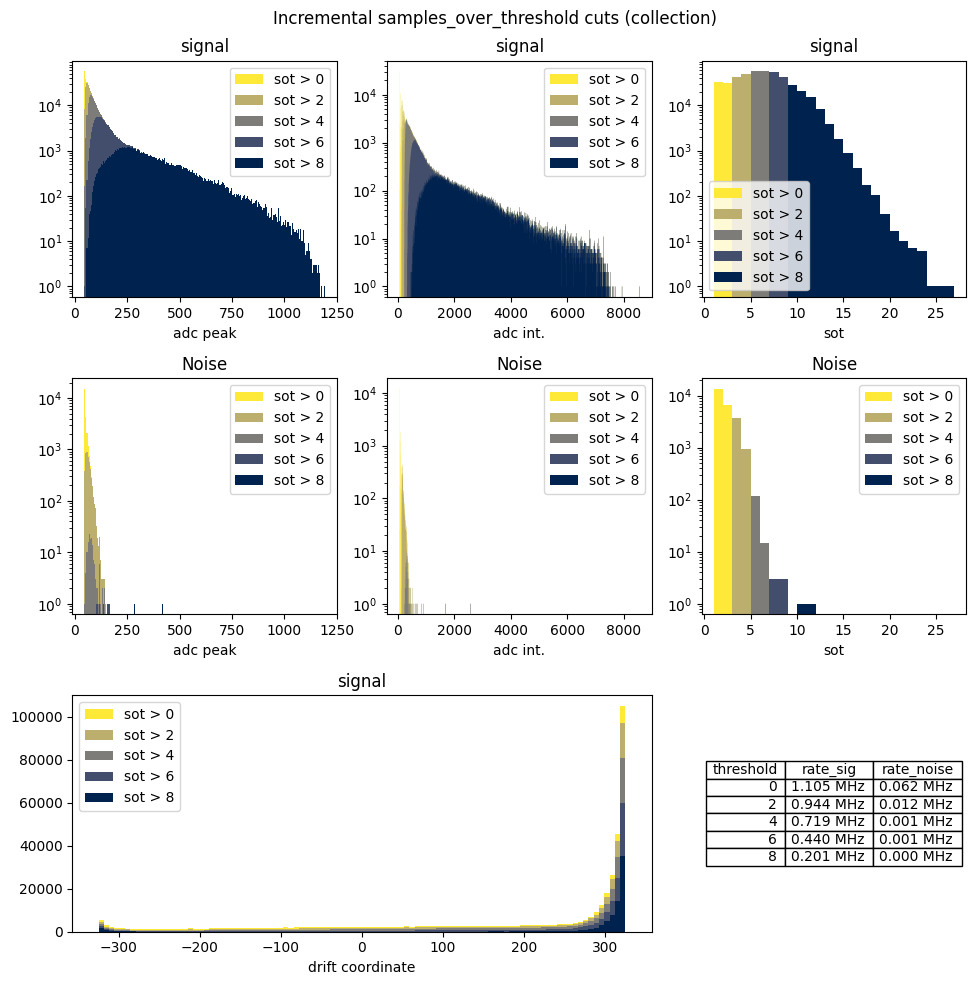

In [ ]:
tot_cuts = [t for t in range(0,10,2)]

fig = tp_ana.draw_variable_cut_sequence('samples_over_threshold', tot_cuts, log=True, figsize=(10,10))


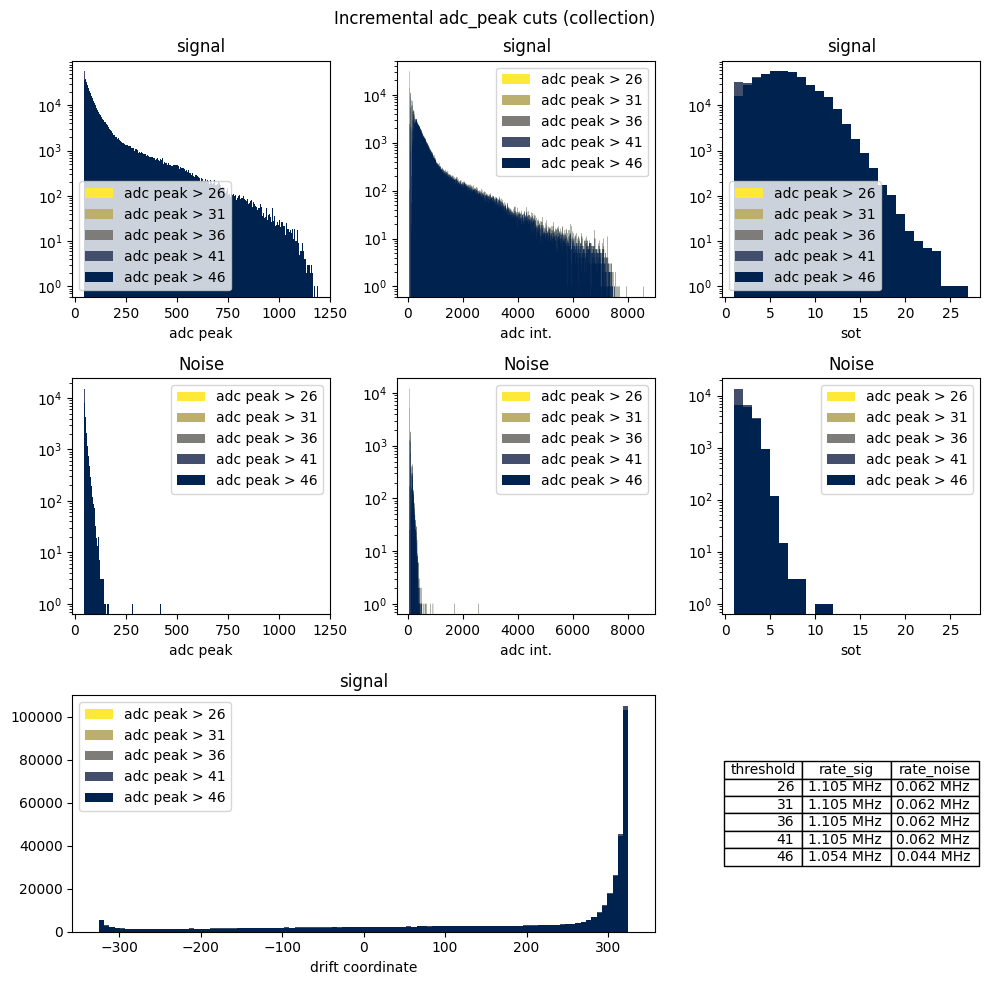

In [24]:
cuts = [t for t in range(26, 50, 5)]

fig = tp_ana.draw_variable_cut_sequence('adc_peak', cuts, log=True, figsize=(10,10))
fig.tight_layout()

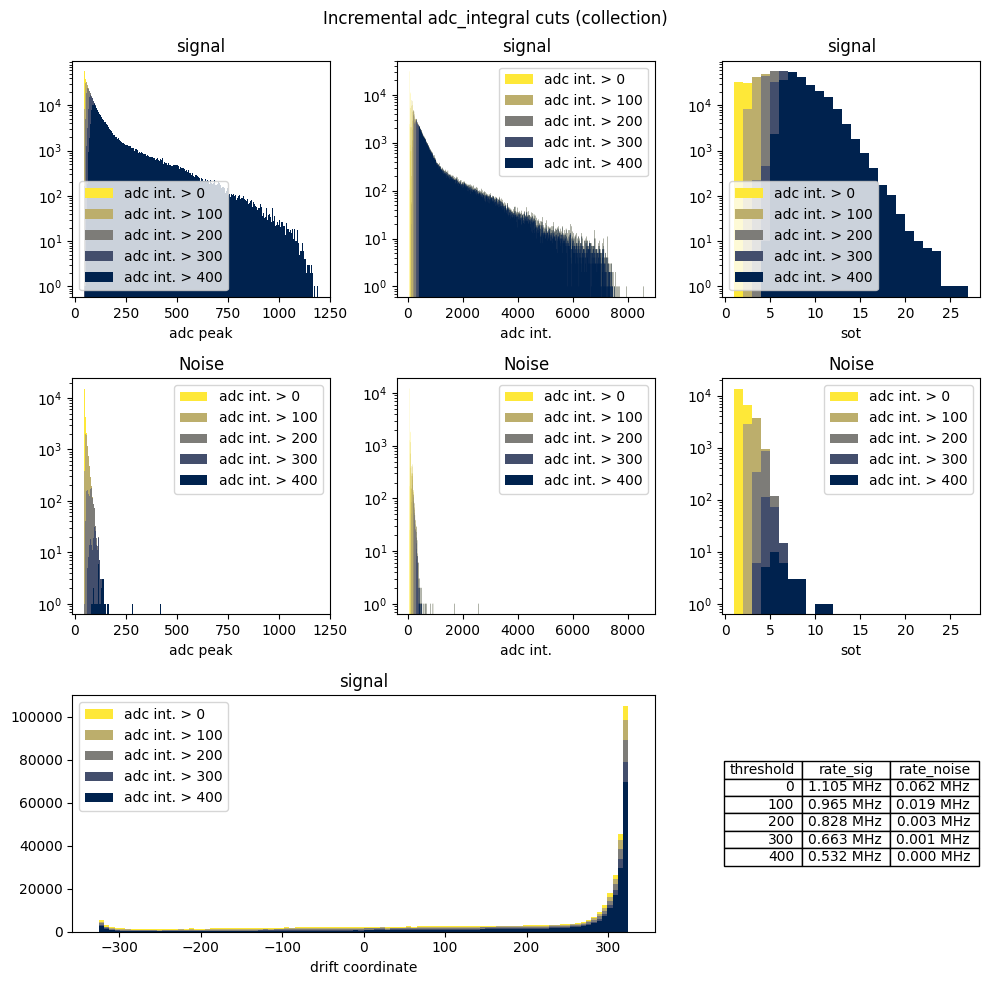

In [25]:
cuts = [t for t in range(0, 500, 100)]

fig = tp_ana.draw_variable_cut_sequence('adc_integral', cuts, figsize=(10,10), log=True)
fig.tight_layout()

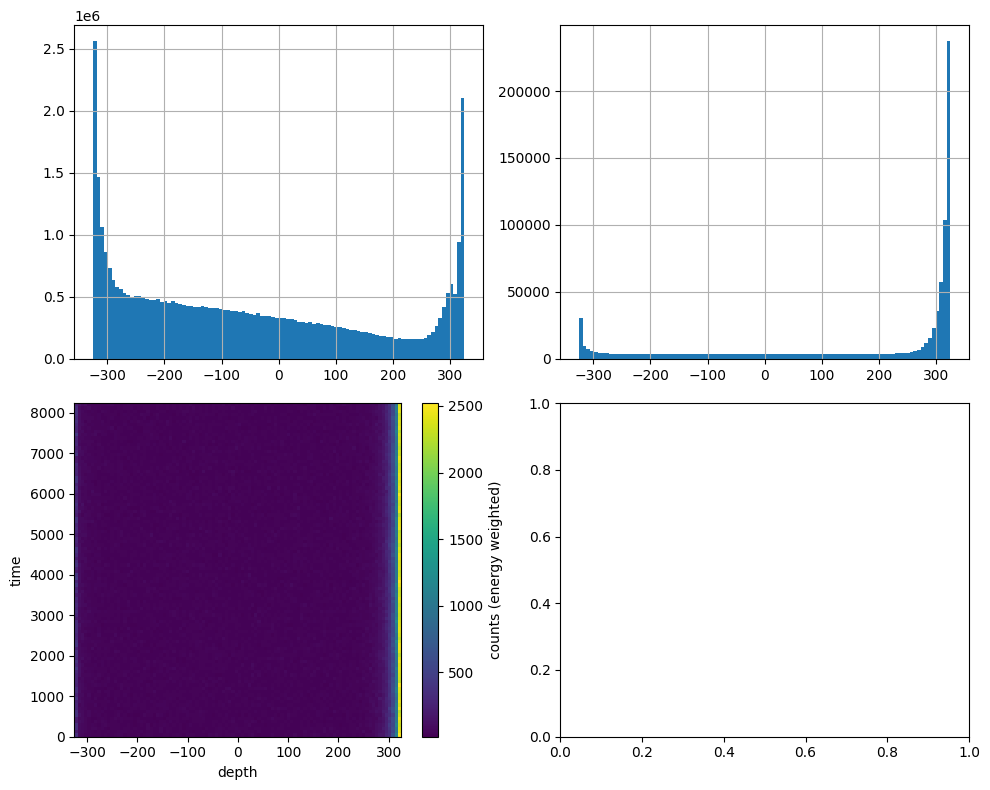

In [26]:
import matplotlib as mpl
fig, axes = plt.subplots(2,2, figsize=(10,8))
norm=mpl.colors.LogNorm()

ides_clean = ws.ides.query('timestamp < 10000')


ax=axes[0][0]
ides_clean.x.hist(bins=100, ax=ax)
ax=axes[0][1]
ides_clean.x.hist(bins=100, weights=ides_clean.energy, ax=ax)
ax = axes[1][0]
h2d = ax.hist2d(ides_clean.x, ides_clean.timestamp, weights=ides_clean.energy, bins=(100, 100))
ax.set_ylabel('time')
ax.set_xlabel('depth')
cbar = fig.colorbar(h2d[3], ax=ax)
cbar.set_label('counts (energy weighted)')
fig.tight_layout()


CavernwallGammasAtLAr1x8x6    197288
Ar39GenInLAr                  195648
Kr85GenInLAr                   28273
foamGammasAtLAr1x8x6            7902
Th232ChainGenInCathode          6546
Th232ChainGenInAnode            6233
U238ChainGenInAnode             2095
U238ChainGenInCathode           1786
Name: count, dtype: int64

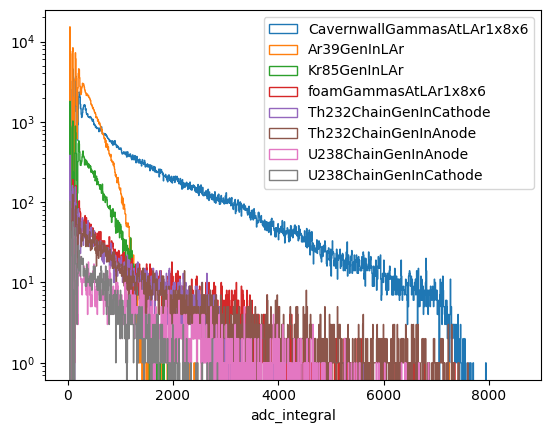

Rate per CRP
CavernwallGammasAtLAr1x8x6    41101.666667
Ar39GenInLAr                  40760.000000
Kr85GenInLAr                   5890.208333
foamGammasAtLAr1x8x6           1646.250000
Th232ChainGenInCathode         1363.750000
Th232ChainGenInAnode           1298.541667
U238ChainGenInAnode             436.458333
U238ChainGenInCathode           372.083333
Name: count, dtype: float64 Hz

In [61]:
tp_bgd = ws.tps[ws.tps.samples_over_threshold >0]
# tp_bgd = ws.tps
# Count entries per generator and get top N culprits
N = 8
# tps_filtered = tp_bgd[(tp_bgd.readout_plane_id == 2)] # & (tp_bgd.samples_over_threshold > 0)]
tps_filtered = tp_bgd.query('bt_is_signal==1 & readout_plane_id == 2') # & (tp_bgd.samples_over_threshold > 0)]
generator_names_np = tps_filtered.bt_generator_name.to_numpy()
top_n = pd.Series(generator_names_np).value_counts().nlargest(N)
print(top_n)
top = pd.Series(generator_names_np).value_counts().nlargest(N).index
plt.yscale('log')
plt.xlabel('adc_integral')

bin_max = max([tps_filtered.loc[tps_filtered.bt_generator_name == top[i]]['adc_integral'].max() for i in range(0,len(top))])
bins=list(range(0, int(bin_max), 8))

for i in range(0,len(top)):
    plt.hist(tps_filtered.loc[tps_filtered.bt_generator_name == top[i], 'adc_integral'], bins=bins, histtype='step', label=f'{top[i]}')
plt.legend()
plt.show()
print(f"Rate per CRP\n{top_n/(100*8000*0.5e-6)/12} Hz")


np.uint16(1193)

CavernwallGammasAtLAr1x8x6    197288
Ar39GenInLAr                  195648
Kr85GenInLAr                   28273
foamGammasAtLAr1x8x6            7902
Th232ChainGenInCathode          6546
Th232ChainGenInAnode            6233
U238ChainGenInAnode             2095
U238ChainGenInCathode           1786
Name: count, dtype: int64

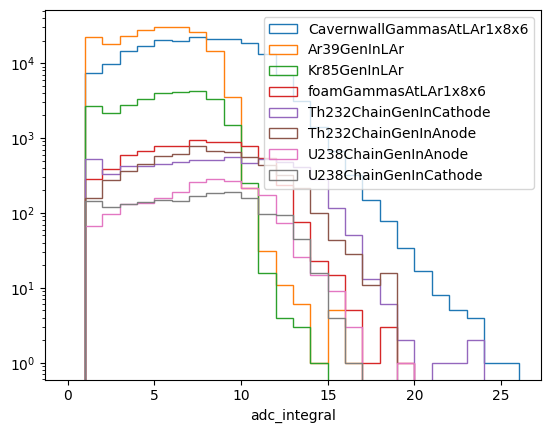

Rate per CRP
CavernwallGammasAtLAr1x8x6    41101.666667
Ar39GenInLAr                  40760.000000
Kr85GenInLAr                   5890.208333
foamGammasAtLAr1x8x6           1646.250000
Th232ChainGenInCathode         1363.750000
Th232ChainGenInAnode           1298.541667
U238ChainGenInAnode             436.458333
U238ChainGenInCathode           372.083333
Name: count, dtype: float64 Hz

In [ ]:
tp_bgd = ws.tps[ws.tps.samples_over_threshold >0]
# tp_bgd = ws.tps
# Count entries per generator and get top N culprits
N = 8
# tps_filtered = tp_bgd[(tp_bgd.readout_plane_id == 2)] # & (tp_bgd.samples_over_threshold > 0)]
tps_filtered = tp_bgd.query('bt_is_signal==1 & readout_plane_id == 2') # & (tp_bgd.samples_over_threshold > 0)]
generator_names_np = tps_filtered.bt_generator_name.to_numpy()
top_n = pd.Series(generator_names_np).value_counts().nlargest(N)
print(top_n)
top = pd.Series(generator_names_np).value_counts().nlargest(N).index
plt.yscale('log')
plt.xlabel('adc_integral')

bin_max = max([tps_filtered.loc[tps_filtered.bt_generator_name == top[i]]['samples_over_threshold'].max() for i in range(0,len(top))])
bins=list(range(bin_max))

for i in range(0,len(top)):
    plt.hist(tps_filtered.loc[tps_filtered.bt_generator_name == top[i], 'samples_over_threshold'], bins=bins, histtype='step', label=f'{top[i]}')
plt.legend()
plt.show()
print(f"Rate per CRP\n{top_n/(100*8000*0.5e-6)/12} Hz")


In [29]:
len(ws.tps.query('bt_is_signal == 1 & readout_plane_id == 2'))/(100*8000*0.5e-6)/12*160/1e6

14.975566666666667

In [30]:
from tpvalidator.utilities import df_to_tp_rates
from rich.table import Table


for i, df in tps_filtered.groupby('bt_generator_name'):
    print(i, df_to_tp_rates(df, 8000))
    # break


pd.DataFrame([[g, df_to_tp_rates(df, 8000)] for g, df in tps_filtered.groupby('bt_generator_name')])


Ar39GenInLAr 489120.0

Ar42GenInLAr 319.4444444444444

CavernwallGammasAtLAr1x8x6 493220.0

K40GenInAnode 1271.0526315789473

K40GenInCathode 953.9473684210526

K42From42ArGenInLAr 450.0

K42From42ArGenInUpperMesh1x8x6 758.3333333333334

Kr85GenInLAr 70682.5

Rn220ChainFromPb212GenInUpperMesh1x8x6 1571.4285714285716

Rn220ChainPb212GenInLAr 1139.8305084745762

Rn222ChainBi214GenInLAr 1847.7011494252872

Rn222ChainFromBi210GenInUpperMesh1x8x6 623.1884057971014

Rn222ChainFromBi214GenInUpperMesh1x8x6 1797.7528089887642

Rn222ChainFromPb214GenInUpperMesh1x8x6 383.33333333333337

Rn222ChainPb214GenInLAr 593.7499999999999

Rn222ChainPo218GenInLAr 379.1666666666667

Rn222ChainRn222GenInLAr 388.8888888888889

Th232ChainGenInAnode 15582.5

Th232ChainGenInCathode 16365.0

U238ChainGenInAnode 5237.5

U238ChainGenInCathode 4465.0

foamGammasAtLAr1x8x6 19755.0

0              1
0                             Ar39GenInLAr  489120.000000
1                             Ar42GenInLAr     319.444444
2               CavernwallGammasAtLAr1x8x6  493220.000000
3                            K40GenInAnode    1271.052632
4                          K40GenInCathode     953.947368
5                      K42From42ArGenInLAr     450.000000
6           K42From42ArGenInUpperMesh1x8x6     758.333333
7                             Kr85GenInLAr   70682.500000
8   Rn220ChainFromPb212GenInUpperMesh1x8x6    1571.428571
9                  Rn220ChainPb212GenInLAr    1139.830508
10                 Rn222ChainBi214GenInLAr    1847.701149
11  Rn222ChainFromBi210GenInUpperMesh1x8x6     623.188406
12  Rn222ChainFromBi214GenInUpperMesh1x8x6    1797.752809
13  Rn222ChainFromPb214GenInUpperMesh1x8x6     383.333333
14                 Rn222ChainPb214GenInLAr     593.750000
15                 Rn222ChainPo218GenInLAr     379.166667
16                 Rn222ChainRn222GenInLAr     388.888889
17                    Th232ChainGenInAnode   15582.500000
18                  Th232ChainGenInCathode   16365.000000
19                     U238ChainGenInAnode    5237.500000
20                   U238ChainGenInCathode    4465.000000
21                    foamGammasAtLAr1x8x6   19755.000000

In [31]:
n_crp_fd = 160
n_crp_sim = 12
n_ev = len(ws.event_summary)
drift_time = 8000*16e-9*31.25

x = n_crp_fd/(n_crp_sim*drift_time*n_ev)


print(x, drift_time)

for i in range(0,len(top)):

    print(top[i], top_n.iloc[i], top_n.iloc[i]*x/1e6 )

33.33333333333332 0.004000000000000001

CavernwallGammasAtLAr1x8x6 197288 6.5762666666666645

Ar39GenInLAr 195648 6.5215999999999985

Kr85GenInLAr 28273 0.942433333333333

foamGammasAtLAr1x8x6 7902 0.26339999999999986

Th232ChainGenInCathode 6546 0.21819999999999992

Th232ChainGenInAnode 6233 0.2077666666666666

U238ChainGenInAnode 2095 0.06983333333333332

U238ChainGenInCathode 1786 0.05953333333333331

In [32]:
tpw.all.groupby('event').sample_start.max()-tpw.all.groupby('event').sample_start.min()

event
1      7997
2      7998
3      7997
4      7995
5      7996
       ... 
96     7997
97     7998
98     7998
99     7997
100    7998
Name: sample_start, Length: 100, dtype: uint64

<Axes: >

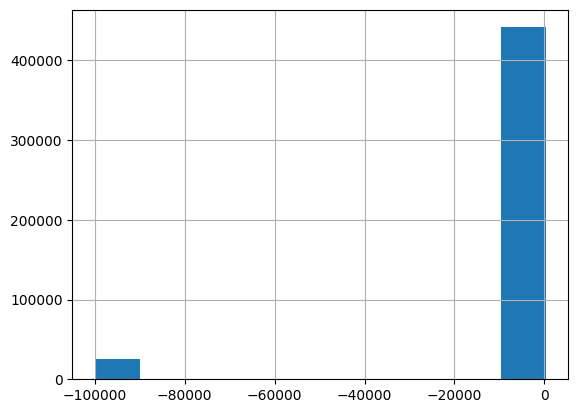

In [33]:
tpw.p2.bt_x.hist()

In [34]:
from tpvalidator.mcprod.backtracker import BackTrackerPlotter

In [35]:
bt = BackTrackerPlotter(ws, 1)

[1]

1

/Users/ale/Development/dune/trigger-studies/tpvalidator/src/tpvalidator/mcprod/workspace.py:399: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



In [36]:
tps_ev1 = tpw.query('event==1')
display(tps_ev1.p2)

event       run  subrun  version  flag  detid  channel  \
230        1  20000047       0        2     0      3      575   
231        1  20000047       0        2     0      3      579   
232        1  20000047       0        2     0      3      581   
233        1  20000047       0        2     0      3      582   
234        1  20000047       0        2     0      3      589   
...      ...       ...     ...      ...   ...    ...      ...   
15327      1  20000047       0        2     0      3    41447   
15329      1  20000047       0        2     0      3    41460   
15330      1  20000047       0        2     0      3    41461   
15331      1  20000047       0        2     0      3    41463   
15332      1  20000047       0        2     0      3    41464   

       samples_over_threshold  time_start  samples_to_peak  ...        bt_z  \
230                        11      240672                5  ...    2.463014   
231                         8      203904                2  ...    4.113769   
232                         5      238528                1  ...    5.587808   
233                         5      238496                2  ...    5.587934   
234                         2      168352                0  ...    9.619730   
...                       ...         ...              ...  ...         ...   
15327                       6      107488                2  ...  883.366821   
15329                       5      146016                1  ...  890.333740   
15330                       5      151936                3  ...  890.589050   
15331                       7      126432                3  ...  891.919006   
15332                       7      126432                2  ...  891.919373   

       bt_primary_x  bt_primary_y  bt_primary_z  bt_truth_block_id  \
230      319.670258   -527.460754      2.463014                  4   
231      324.980713   -610.880554      4.113769                  4   
232      202.228945   -648.850063      5.587808                  9   
233      202.229052   -648.850310      5.587934                  9   
234      -51.374878   -537.827332      9.619730                  9   
...             ...           ...           ...                ...   
15327    159.554596    660.472046    883.366821                  9   
15329    252.812531    622.178406    890.333740                  4   
15330   -285.638763    622.986572    890.589050                  9   
15331    181.394562    599.174072    891.919006                  9   
15332    181.393539    599.174927    891.919373                  9   

                bt_generator_name  time_peak  sample_start  sample_peak  \
230    CavernwallGammasAtLAr1x8x6     241024          7521         7532   
231    CavernwallGammasAtLAr1x8x6     204160          6372         6380   
232                  Ar39GenInLAr     238688          7454         7459   
233                  Ar39GenInLAr     238656          7453         7458   
234                  Ar39GenInLAr     168416          5261         5263   
...                           ...        ...           ...          ...   
15327                Ar39GenInLAr     107680          3359         3365   
15329  CavernwallGammasAtLAr1x8x6     146176          4563         4568   
15330                Ar39GenInLAr     152096          4748         4753   
15331                Ar39GenInLAr     126656          3951         3958   
15332                Ar39GenInLAr     126656          3951         3958   

       bt_is_signal  
230            True  
231            True  
232            True  
233            True  
234            True  
...             ...  
15327          True  
15329          True  
15330          True  
15331          True  
15332          True  

[4632 rows x 32 columns]

In [37]:
tps_ev1.p2.query("adc_integral < 1000").iloc[:9]

event       run  subrun  version  flag  detid  channel  \
231      1  20000047       0        2     0      3      579   
232      1  20000047       0        2     0      3      581   
233      1  20000047       0        2     0      3      582   
234      1  20000047       0        2     0      3      589   
235      1  20000047       0        2     0      3      589   
236      1  20000047       0        2     0      3      592   
237      1  20000047       0        2     0      3      597   
238      1  20000047       0        2     0      3      598   
239      1  20000047       0        2     0      3      605   

     samples_over_threshold  time_start  samples_to_peak  ...       bt_z  \
231                       8      203904                2  ...   4.113769   
232                       5      238528                1  ...   5.587808   
233                       5      238496                2  ...   5.587934   
234                       2      168352                0  ...   9.619730   
235                       5      236480                2  ...   9.189946   
236                       4      167424                1  ...  10.854382   
237                       5      209216                3  ...  13.741132   
238                       3      209280                1  ...  13.741568   
239                       2      236224                1  ...  17.347942   

     bt_primary_x  bt_primary_y  bt_primary_z  bt_truth_block_id  \
231    324.980713   -610.880554      4.113769                  4   
232    202.228945   -648.850063      5.587808                  9   
233    202.229052   -648.850310      5.587934                  9   
234    -51.374878   -537.827332      9.619730                  9   
235    324.967590   -617.850891      9.189946                  4   
236    324.482452   -528.155212     10.854382                  4   
237    280.423767   -591.860229     13.741132                  9   
238    280.424011   -591.861084     13.741568                  9   
239    322.381683   -614.223816     17.347942                  4   

              bt_generator_name  time_peak  sample_start  sample_peak  \
231  CavernwallGammasAtLAr1x8x6     204160          6372         6380   
232                Ar39GenInLAr     238688          7454         7459   
233                Ar39GenInLAr     238656          7453         7458   
234                Ar39GenInLAr     168416          5261         5263   
235  CavernwallGammasAtLAr1x8x6     236640          7390         7395   
236  CavernwallGammasAtLAr1x8x6     167552          5232         5236   
237                Ar39GenInLAr     209376          6538         6543   
238                Ar39GenInLAr     209376          6540         6543   
239  CavernwallGammasAtLAr1x8x6     236288          7382         7384   

     bt_is_signal  
231          True  
232          True  
233          True  
234          True  
235          True  
236          True  
237          True  
238          True  
239          True  

[9 rows x 32 columns]

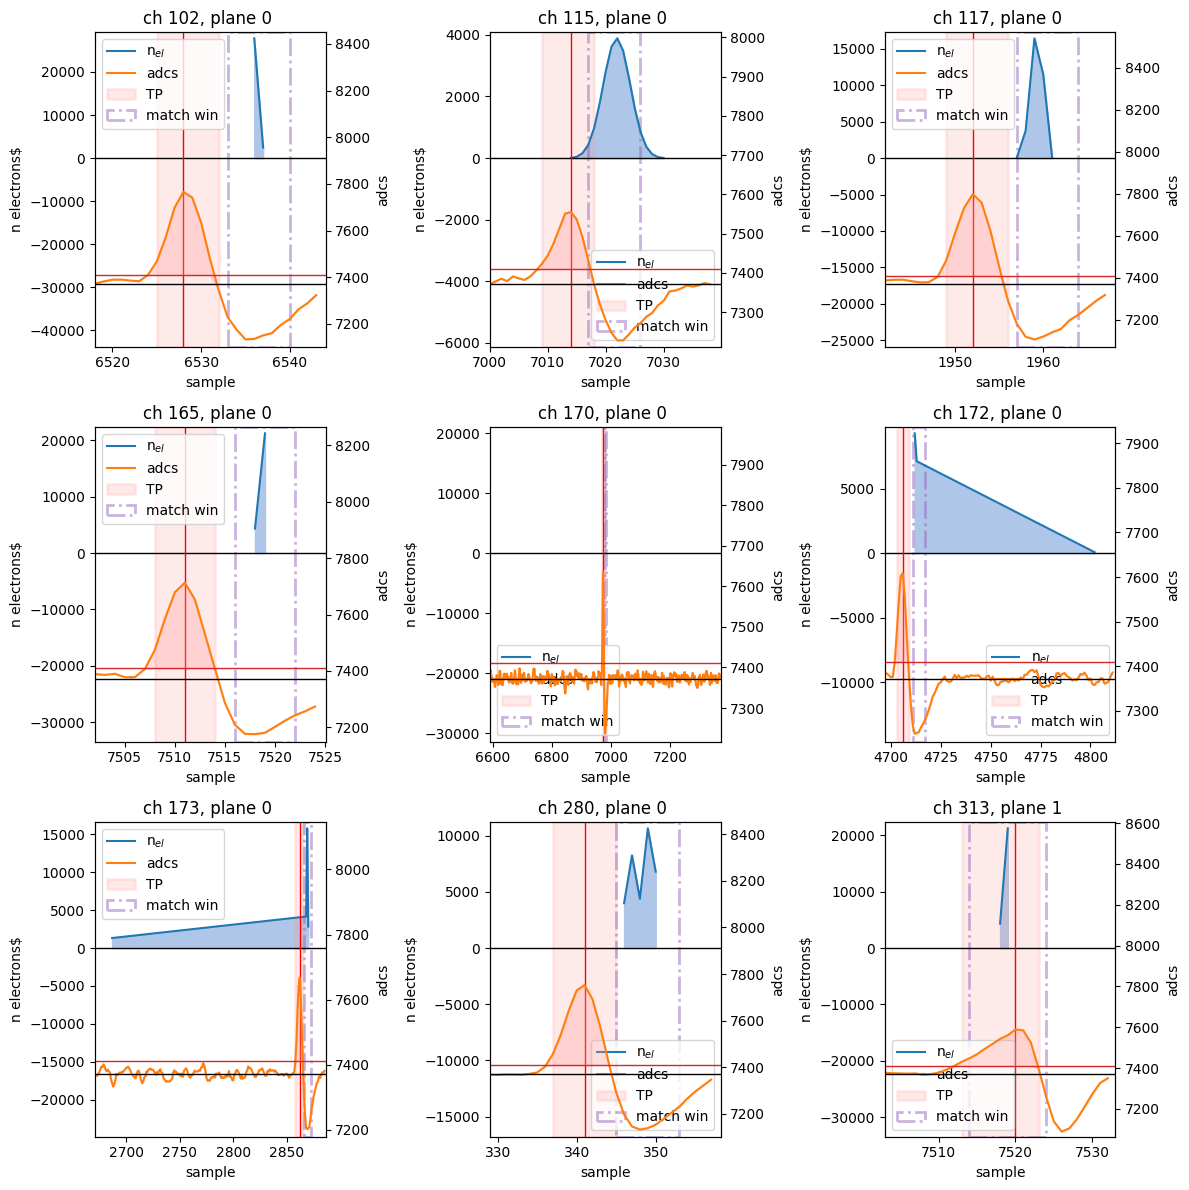

In [38]:
bt.plot_tps_vs_ides(bt.inspect_tps.query('adc_integral > 1000 & bt_is_signal == 1').iloc[:9], figsize=(12,12))
